In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random 

## 构建初始网络

### 抽取子图

In [2]:
#基于数据集生成子图（点+边）
def sub_graph():
    data=pd.read_csv("D:/pythonwork/edge.csv")   #从csv读取连边
    res=[[] for i in range(6726290)] #创建二维列表，6726290为节点总数
    for line in data.values:
        res[line[0]].append(line[1])  #根据data中的数据，res中存储结构为：res[节点编号]=节点邻居列表
        res[line[1]].append(line[0])
    dct={i:res[i] for i in range(len(res))}  #数据类型转换，定义邻居字典，格式为 节点：邻居节点列表
    allnodes=[i for i in range(6726290)]  #定义节点列表
    allnodes_set=set(allnodes)  #将列表转换为集合，以提高运行效率
    
    nodes_selected_set=set()  #用于存储被抽取的节点的集合
    count=0   #计数，判断抽取节点个数是否达到上限
    α=0.5 #调节回跳概率
    β=0.5 #调节DFS的概率

    node_father=random.choice(allnodes) #随机选择开始的节点node_father，作为开始的节点
    nodes_selected_set.add(node_father)  
    count=count+1
    fa_neib_nodes_set=set(dct[node_father]) #父节点的邻域节点，即从dct中读出node_father的邻居列表
    print("【计数，节点number，节点邻居列表】")
    print(count,node_father,fa_neib_nodes_set)

    node_cur=random.choice(dct[node_father]) #从父节点的邻居列表中随机抽取下一步节点，作为当前节点node_cur
    nodes_selected_set.add(node_cur)  
    count=count+1
    cur_neib_nodes_set=set(dct[node_cur])
    print(count,node_cur,cur_neib_nodes_set)

    while count<2000:
        pro_lst=[None]*len(dct[node_cur])
        for i in cur_neib_nodes_set:
            index1=dct[node_cur].index(i)
            if i in fa_neib_nodes_set: #当前节点和上级节点的共同节点，概率为1
                pro_lst[index1]=1
            elif i==node_father: #回溯上级节点，概率为α
                pro_lst[index1]=α
            else:                #仅为当前节点的邻居节点，即距离上级节点的最短路径为2，概率为β
                pro_lst[index1]=β
        total_pro=sum(pro_lst)
        for j in range(len(pro_lst)-1):#概率列表归一化
            pro_lst[j]=pro_lst[j]/total_pro
        pro_lst[len(pro_lst)-1]=1-sum(pro_lst[:len(pro_lst)-1])

        node_cand=np.random.choice(list(dct[node_cur]),p=pro_lst)  #选择下一个节点

        if node_cand not in nodes_selected_set: #如果节点未重复取到，添加到抽取节点列表
            nodes_selected_set.add(node_cand)
            count=count+1
            print(count,node_cand,dct[node_cand])
        #更新迭代变量
        node_father=node_cur 
        fa_neib_nodes_set=set(dct[node_father]) 
        node_cur=node_cand
        cur_neib_nodes_set=set(dct[node_cur])

    tmp=np.array(list(nodes_selected_set))
    np.save('selected.npy',tmp) 
    a=np.load('selected.npy')
    a=a.tolist()
    G=nx.Graph()
    data=pd.read_csv("d:/pythonwork/edge.csv")   #读取边集合，用于后续遍历
    eset=set()
    data1=np.array(data)
    for i in data1:
        eset.add(tuple(i))  #处理边的数据结构，将其转化为（i,j）元素组成的集合        
    enodes=set(a)  #转化为集合，遍历速度比list快得多
    edge_part=set() #存储点集中两点之间的联系
    for i in enodes:
        for j in enodes:
            if tuple((i,j)) in eset or tuple((i,j)) in eset:
                edge_part.add(tuple((min(i,j),max(i,j))))
    print("【节点总数，连边总数】")
    print(len(enodes),len(edge_part))
    G.add_nodes_from(list(a)) #将点和边用于创建图G
    G.add_edges_from(list(edge_part))
    nx.draw(G,node_size=10)  
    return G

### 赋予属性 

In [3]:
#定义节点类，即通过多智能体为每个个体赋予属性和改变属性的方法
class ini_nodes: 
    def __init__(self,name):  #构造函数
        self.school=0  #学校属性，固定不变
        self.enterprise=0  #企业属性，求职成功、离职时改变
        self.hr_ability=np.random.normal(0.5,0.167)  #人力资本，求职的能力，创建对象时随机生成，整体呈正态分布
        self.apply_rate=[0.1,0.3,0.5,0.7,0.9]  #初始投递意向（未添加社会资本的影响）
        self.apply=[False,False,False,False,False]  #是否发生投递行为
        self.relations=[0,0,0,0,0]  #分别与五家企业内在职者的联系条数
        self.name=name
    def schooldef(self,school):   #修改学校属性
        self.school=school
    def enterprisedef(self,enterprise):  #修改企业属性 
        self.enterprise=enterprise
    def apply_change(self,i,bool):  #修改单个投递行为
        self.apply[i]=bool
    def relations_change(self,i,num):  #修改单个联系条数
        self.relations[i]=num   
    def apply_rate_change(self):  #基于联系条数重新计算单个投递意向
        for i in range(5):
            self.apply_rate[i]=min(1,float(self.apply_rate[i])* (2-((1-0.1)**int(self.relations[i]))))  #会员闭包的影响暂取0.1
    #定义初始化函数
    def apply_to_ini(self):  #投递行为初始化
        self.apply=[False,False,False,False,False]
    def relations_to_zero(self):  #联系条数初始化
        self.relations=[0,0,0,0,0]
    def apply_rate_to_ini(self):   #投递意向初始化
        self.apply_rate=[0.1,0.3,0.5,0.7,0.9]

In [4]:
#创建2000个同名节点对象，其中求职者占23%（jobseeker）和在职者占77%（employee），并分别为其赋予学校、企业属性
def nodes_classify(G1):
    G=nx.Graph()
    G=G1
    nodes_list=G.nodes()#获取图的节点列表
    jobseeker=random.sample(nodes_list,int(0.23 * 2000)) #随机抽取23%作为求职者
    employee=[]
    for i in nodes_list:  #其他的加入在职者列表
        if i not in jobseeker:
            employee.append(i)
    #创建初始节点对象，将创建好的对象按照节点编号归到两个list中
    obj_list_jobseeker=[]  #求职者对象列表
    obj_list_employee=[]   #在职者对象列表
    for i in jobseeker:
        i=ini_nodes(i)
        obj_list_jobseeker.append(i)
    for j in employee:
        j=ini_nodes(j)
        obj_list_employee.append(j)

    #分配学校、企业属性：
    #1.学校：把包含所有节点的列表打乱，然后取切片，切片比例为1:1:1:1:1
    obj_list=obj_list_employee+obj_list_jobseeker
    random.shuffle(obj_list)
    school_N=[]
    a=int(len(obj_list)/5)
    school_N.append(obj_list[:a])
    school_N.append(obj_list[a:2*a])
    school_N.append(obj_list[2*a:3*a])
    school_N.append(obj_list[3*a:4*a])
    school_N.append(obj_list[4*a:])
    for item in school_N:
        for obj in item:
            obj.schooldef(school_N.index(item)+1) #将对象所处列表的索引值+1作为学校属性赋给对象
    #2.企业：将在职者的节点打乱，然后取切片,切片比例为1:3:5:7:9
    random.shuffle(obj_list_employee)
    employee_N=[]
    b=int(len(obj_list_employee)/25)
    employee_N.append(obj_list_employee[:b])
    employee_N.append(obj_list_employee[b:4*b])
    employee_N.append(obj_list_employee[4*b:9*b])
    employee_N.append(obj_list_employee[9*b:16*b])
    employee_N.append(obj_list_employee[16*b:])
    for item in employee_N:
        for obj in item:
            obj.enterprisedef(employee_N.index(item)+1) #将在职者对象所处列表的索引值+1作为企业属性赋给对象
    return obj_list_jobseeker,obj_list_employee,employee_N

【计数，节点number，节点邻居列表】
1 6022492 {539120, 1736615}
2 1736615 {2114436, 142891, 539120, 4392722, 24594, 5929362, 5091832, 6022492}
3 539120 [733733, 1736615, 5803112, 1510825, 4298027, 4392722, 3125585, 5929362, 1217749, 6022492, 4748797]
4 1217749 [539120, 733733, 973259, 5972645, 5010922, 3631662, 3125585, 6273266, 3496473, 5671133]
5 3125585 [539120, 733733, 973259, 1217749, 1510825]
6 1510825 [539120, 733733, 973259, 5803112, 4298027, 3631662, 3125585, 4392722, 3496473]
7 973259 [733733, 5972645, 1510825, 5010922, 3631662, 3125585, 6273266, 1217749, 3496473, 5671133]
8 733733 [539120, 973259, 1510825, 1999594, 4298027, 3631662, 3125585, 5625780, 1217749, 3496473, 4748797]
9 4298027 [539120, 733733, 1510825]
10 3631662 [733733, 973259, 1217749, 1510825]
11 5671133 [973259, 1217749]
12 3496473 [733733, 973259, 1217749, 1510825]
13 5972645 [973259, 1217749]
14 5010922 [973259, 1217749]
15 4748797 [539120, 733733]
16 5929362 [539120, 1736615]
17 4392722 [539120, 1510825, 1736615]
18 62732

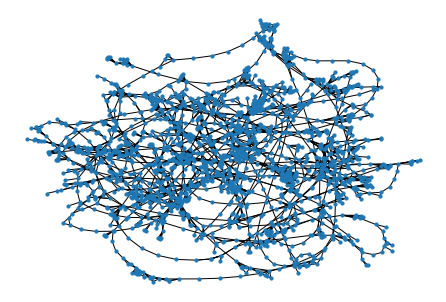

In [5]:
#构建初始网络（调用函数）
G=sub_graph() #创建子图
obj_list_jobseeker,obj_list_employee,employee_N=nodes_classify(G) #创建节点同名对象，为求职者、在职者赋予属性
#定义全局变量
job_num=len(obj_list_jobseeker) #定义待招岗位的数量，若接收则该岗位数量-1，若离职则该岗位数量+1
job_num_list=[int(job_num/25),int(3*job_num/25),int(5*job_num/25),int(7*job_num/25),int(9*job_num/25)]  #按照切片比例1:3:5:7:9分配给五家公司
exit_rate=0.188  #离职率
#记录新增联系、新增各企业在职者数量、新增离职者数量
new_relation=[]
new_employed=[]
new_exited=[]

## 人员流动

### 投递

In [6]:
#函数：更新求职对象的投递概率，将基于每个公司在职的好友联系数量更新
def cal_apply_rate(): 
    print("【节点number，节点与五个公司在职者连边的数量，节点对五家企业的投递概率】")
    for obj in obj_list_jobseeker:
        obj.relations_to_zero() #先对每个求职者的联系数量进行初始化
        friends=list(G.neighbors(obj.name))
        for item in obj_list_employee:  #对每个求职者进行遍历，如果邻居为求职者，则该企业的relations＋1
            if item.name in friends:
                obj.relations_change(int(item.enterprise)-1,obj.relations[int(item.enterprise)-1]+1)
        obj.apply_rate_change()   #根据relations重新计算apply_rate
        print(obj.name,obj.relations,obj.apply_rate)

In [7]:
#函数：基于apply_rate判断投递与否
def apply():
    print("【节点number，节点是否投递五家企业】")
    for obj in obj_list_jobseeker:
        obj.apply_to_ini()  #初始化apply列表，将值均变为false
        for i in range(5):   #求职者针对每家企业随机产生概率p1，p1<apply_rate则投递
            p1=np.random.random()
            if p1<= obj.apply_rate[i]:
                obj.apply_change(i,True)
        print(obj.name,obj.apply)

### 接收

In [8]:
#模拟企业接收流程
def accept():
    successed=[[],[],[],[],[]] #用于记录各公司本轮录用的求职者
    obj_list_jobseeker_set=set(obj_list_jobseeker)
    enter_list=[0,1,2,3,4]
    random.shuffle(enter_list)  #将公司的顺序打乱
    for i in enter_list:  #计数，计算申请该企业的总人数，用于计算企业的招聘门槛，后续需优化算法
        applyed=set()
        for obj in obj_list_jobseeker_set:
            if obj.apply[i]==True:
                applyed.add(obj)
        accept_rate=round((len(applyed)/len(obj_list_jobseeker))**2,4)  #企业的招聘门槛（待定，暂用（申请人数/总人数）**2，取4位小数，企业5招聘门槛仍然过高）
        print("【企业编号：",i+1,"，招聘门槛：",accept_rate,"】")
        candidate=[] #候选人列表：将投递该企业并且满足企业的招聘门槛的求职者加入列表
        for obj in applyed:   #按照乱序，让5个公司挨个进行录用流程
            if accept_rate <= obj.hr_ability:
                candidate.append(obj)
        candidate.sort(key=lambda x:x.hr_ability,reverse=True) #根据人力资本对候选人进行降序排序
        #根据Hospital-Resident算法，对候选人列表进行邀请：1.无offer的直接录用；2.已有offer不如i公司，放弃原公司，被i公司录用；3.已有offer更好，不发offer
        for cand in candidate:
            if job_num_list[i]>0:
                if cand.enterprise==0:
                    cand.enterprisedef(i+1)
                    job_num_list[i]=job_num_list[i]-1  #本公司招聘数量-1
                    print(cand.name,i+1,accept_rate,cand.hr_ability)
                elif cand.enterprise!=0 and cand.apply_rate[i]>cand.apply_rate[int(cand.enterprise)-1]:
                    cand.enterprisedef(i+1)
                    job_num_list[i]=job_num_list[i]-1  #本公司招聘数量-1
                    job_num_list[int(cand.enterprise)-1]=job_num_list[int(cand.enterprise)-1]+1  #所放弃的原录用公司招聘数量+1
                    print(cand.name,i+1,accept_rate,cand.hr_ability)    
            else:
                break
                    
    #计算本轮录用结果：obj_list_jobseeker中enterprise不为0的求职者即为求职成功，将其从求职者列表中删除，加入在职者列表        
    for item in obj_list_jobseeker:
        if item.enterprise!=0:
            employee_N[int(item.enterprise)-1].append(item) 
            obj_list_employee.append(item)
            obj_list_jobseeker.remove(item)
            successed[int(item.enterprise)-1].append(item)
    new_employed.append([len(successed[0]),len(successed[1]),len(successed[2]),len(successed[3]),len(successed[4])]) #记录本轮成功求职的总人数
    print("各企业成功招聘人数：",new_employed)

### 离职

In [9]:
#模拟离职流程
def departure():
    exited=[[],[],[],[],[]]
    for i in range(5): # 5个公司依次模拟离职
        for cand in employee_N[i]:
            p2=np.random.normal(0.5,0.167)
            if p2 <= exit_rate:
                cand.enterprisedef(0)
                employee_N[i].remove(cand) 
                obj_list_employee.remove(cand)
                obj_list_jobseeker.append(cand)
                job_num_list[i]=job_num_list[i]+1
                exited[i].append(cand)
    new_exited.append([len(exited[0]),len(exited[1]),len(exited[2]),len(exited[3]),len(exited[4])])  #记录本轮离职的人数
    print("各企业离职人数：",new_exited)    

In [10]:
cal_apply_rate() #计算投递概率
apply()  #模拟投递行为
accept()  #模拟录取行为
departure()  #模拟离职行为

【节点number，节点与五个公司在职者连边的数量，节点对五家企业的投递概率】
3185036 [0, 0, 0, 0, 1] [0.1, 0.3, 0.5, 0.7, 0.9900000000000001]
555493 [0, 0, 0, 1, 3] [0.1, 0.3, 0.5, 0.77, 1]
3364874 [0, 0, 0, 1, 2] [0.1, 0.3, 0.5, 0.77, 1]
1139778 [0, 1, 0, 2, 3] [0.1, 0.33, 0.5, 0.833, 1]
990907 [0, 0, 0, 3, 0] [0.1, 0.3, 0.5, 0.8896999999999998, 0.9]
1117548 [0, 0, 0, 1, 1] [0.1, 0.3, 0.5, 0.77, 0.9900000000000001]
2955343 [0, 0, 1, 0, 1] [0.1, 0.3, 0.55, 0.7, 0.9900000000000001]
5664660 [0, 0, 0, 0, 0] [0.1, 0.3, 0.5, 0.7, 0.9]
1703785 [0, 0, 1, 0, 1] [0.1, 0.3, 0.55, 0.7, 0.9900000000000001]
2335236 [0, 0, 0, 0, 1] [0.1, 0.3, 0.5, 0.7, 0.9900000000000001]
2508722 [1, 0, 0, 0, 1] [0.11000000000000001, 0.3, 0.5, 0.7, 0.9900000000000001]
2759813 [0, 1, 0, 0, 1] [0.1, 0.33, 0.5, 0.7, 0.9900000000000001]
854776 [0, 0, 0, 0, 2] [0.1, 0.3, 0.5, 0.7, 1]
4444854 [0, 0, 0, 0, 1] [0.1, 0.3, 0.5, 0.7, 0.9900000000000001]
1248752 [0, 0, 1, 2, 2] [0.1, 0.3, 0.55, 0.833, 1]
6336690 [0, 0, 0, 1, 0] [0.1, 0.3, 0.5, 0.77, 0.9]
2808456 [

## 新增人际联系 

In [11]:
#函数：新增人际联系
def relationship(num1,num2): #传入2个0，1变量，num1控制是否允许三度连接，num2控制是否社团闭包
    enable_3_con=int(num1)
    enable_club=int(num2)
    new_relation_1=[] #记录本轮新增连接
    for node1 in obj_list_jobseeker:#对每一个求职者对象，寻找其二度、三度好友列表，分别存储在degree_nodes_2、degree_nodes_3
        degree_nodes_2=list(nx.single_source_shortest_path_length(G,node1.name,2))
        degree_nodes_3=list(nx.single_source_shortest_path_length(G,node1.name,3))
        for i in range(5):
            for node2 in employee_N[i]: #对每个企业中的在职者，在二度、三度好友列表中，则可能新增联系
                if node2.name in degree_nodes_2: #2度好友
                    p3=np.random.random()
                    n=len(list(nx.common_neighbors(G,node1.name,node2.name))) #n为共同好友的数量，三元闭包的影响暂取0.3，多个共同好友时为[1-(1-0.3)**n]
                    if node1.school==node2.school: #两节点若为校友关系，则考虑社团闭包，影响暂取0.2
                        if p3<=min(1,((1-(1-0.3)**n)+0.2*enable_club-(1-(1-0.3)**n)*0.2*enable_club)):  #三元闭包+社团闭包-三元闭包*社团闭包
                            G.add_edge(node1.name,node2.name)  #新增联系
                            new_relation_1.append((node1.name,node2.name))
                    else:
                        if p3<=min(1,(1-(1-0.3)**n)): #非校友时，仅考虑三元闭包
                            G.add_edge(node1,node2)
                            new_relation_1.append((node1.name,node2.name))
                        
                elif node2.name in degree_nodes_3:#3度好友，三度连接影响暂取0.2，不受中间好友影响。
                    p3=np.random.random()
                    if node1.school==node2.school:
                        if p3<=min(1,(0.2*enable_3_con+0.2*enable_club-0.2*enable_3_con*0.2*enable_club)): #校友关系，三度连接+社团闭包-三度连接*社团闭包
                            G.add_edge(node1.name,node2.name)
                            new_relation_1.append((node1.name,node2.name))
                    else:
                        if p3<=min(1,0.2*enable_3_con): #非校友时，仅考虑三度连接
                            G.add_edge(node1.name,node2.name)
                            new_relation_1.append((node1.name,node2.name))
    new_relation.append(len(new_relation_1)) #记录本轮新增关系数量
    print("【新增联系总数，罗列新增联系】")
    print(new_relation,new_relation_1)

In [12]:
relationship(1,1) 

【新增联系总数，罗列新增联系】
[1999] [(3185036, 877121), (3185036, 1245831), (3185036, 185051), (555493, 1300380), (555493, 2856653), (555493, 1555168), (555493, 2067828), (555493, 6513217), (555493, 2759813), (555493, 88946), (555493, 1689902), (555493, 725974), (555493, 1308874), (555493, 139135), (555493, 2216187), (555493, 1271595), (1139778, 3909036), (1139778, 1232994), (1139778, 3858090), (1139778, 76111), (1139778, 327585), (1139778, 847214), (1139778, 404778), (1139778, 469929), (1139778, 2110473), (1139778, 55337), (1117548, 1142985), (1117548, 3078054), (1117548, 219388), (2955343, 6511331), (2955343, 6030659), (2955343, 761405), (2955343, 1210124), (5664660, 1232994), (5664660, 3858090), (5664660, 327585), (5664660, 847214), (5664660, 404778), (5664660, 469929), (5664660, 1287603), (5664660, 55337), (2335236, 47568), (2335236, 272110), (2335236, 59404), (2335236, 51186), (2508722, 1377719), (854776, 1904030), (1248752, 97837), (1248752, 930412), (1248752, 212600), (2808456, 657737), (280

In [13]:
#如果只考虑人力资本对投递阶段的影响，那么新增联系只会影响求职者是否愿意投递，而不会影响是否被录用，因此在求职结果上没有明显影响。
#后续工作：1.加入seed方法用于记录；2.加入量化指标，多维度对比得到社团闭包、会员闭包、三度连接对求职效率的影响。